In [7]:
from __future__ import absolute_import, print_function,division, unicode_literals

import os.path
import glob
import shutil

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation
from keras import regularizers
import keras

In [8]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [10]:
print(tf.__version__)

2.5.0


In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [12]:
data_dir = "/home/hum/SCHOOL PROJECT/Third-Year-Project/Images/"
data_dir = pathlib.Path(data_dir)


print('Class Names: ', CLASS_NAMES)

Class Names:  ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [39]:
#Group into train, test and validation sets
for cl in CLASS_NAMES:
    data_path = os.path.join(data_dir, cl)
    images = glob.glob(data_path + "/*")
    print("{} :{} ".format(cl,len(images)))
    train, val = images[:round(len(images)*0.8)],images[round(len(images)*0.8):]
    
    for t in train:
        if not os.path.exists(os.path.join(data_dir, 'train', cl)):
            os.makedirs(os.path.join(data_dir, 'train', cl))
        shutil.move(t,os.path.join(data_dir, 'train', cl))
        
    for v in val:
        if not os.path.exists(os.path.join(data_dir, 'val', cl)):
            os.makedirs(os.path.join(data_dir, 'val', cl))
        shutil.move(v,os.path.join(data_dir, 'val', cl))
    

Mild :0 
Moderate :0 
No_DR :0 
Proliferate_DR :0 
Severe :0 


In [40]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

In [41]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 15288 images belonging to 5 classes.
Found 953 images belonging to 5 classes.


In [42]:
def plotImages(img_arr):
    fig,axes = plt.subplots(1, 5,  figsize = (25, 25))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

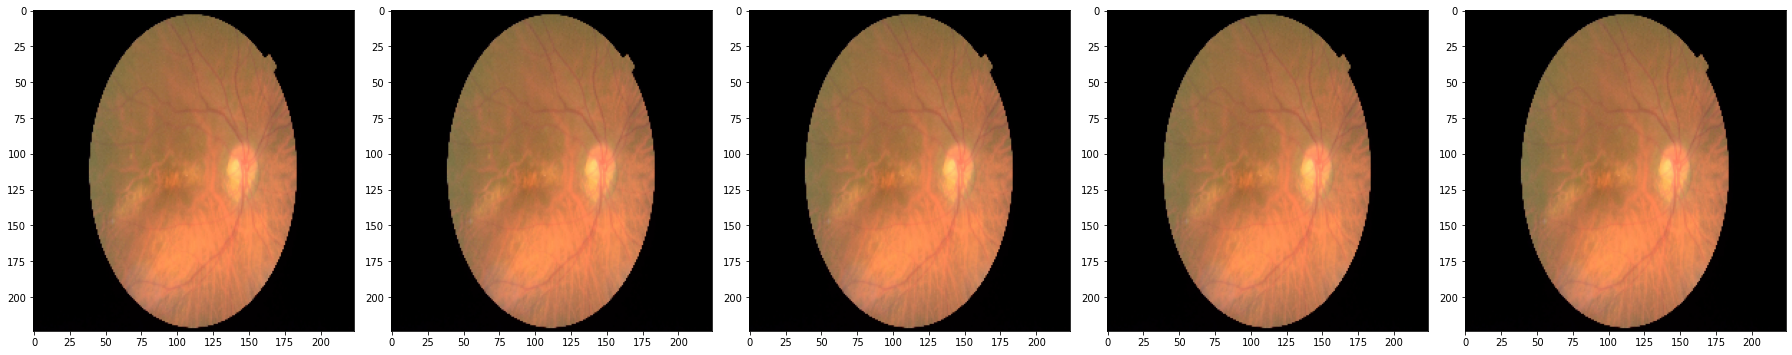

In [43]:
#plot a few train images
img_array = [train_generator[0][0][0] for i in range(5)]
plotImages(img_array)

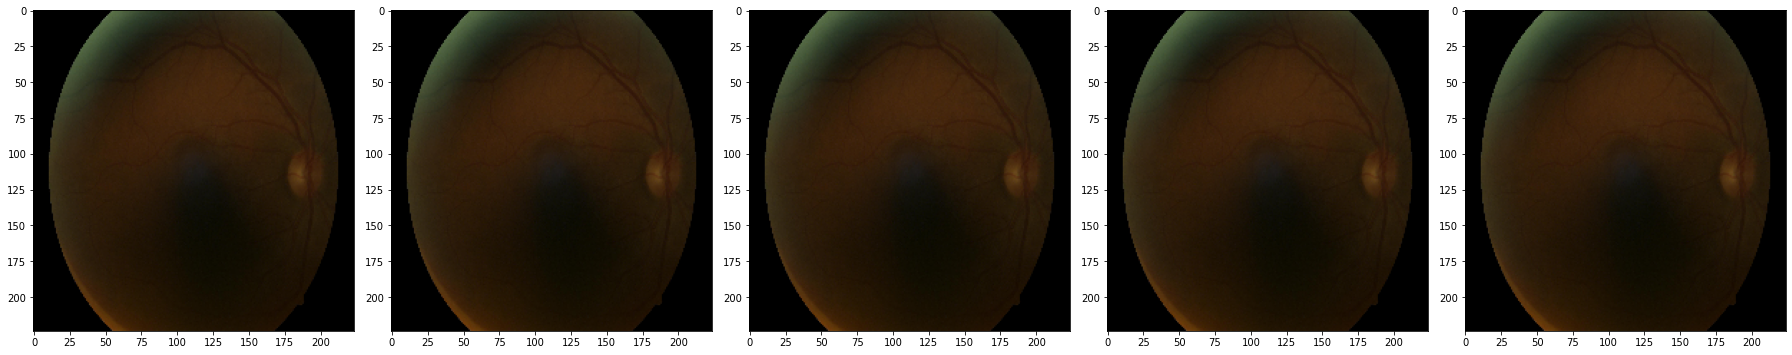

In [44]:
# plot a few val images
img_array  = [val_generator[0][0][0] for i in range(5)]
plotImages(img_array)

In [45]:
IMG_SHAPE = (IMG_HEIGHT,IMG_WIDTH,3)

In [46]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [47]:
base_model.trainable = False

In [48]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [51]:
epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
478/478 [==============================] - 549s 1s/step - loss: 1.1273 - accuracy: 0.6056 - val_loss: 0.9997 - val_accuracy: 0.6013
Epoch 2/10
478/478 [==============================] - 528s 1s/step - loss: 1.0014 - accuracy: 0.6143 - val_loss: 0.9942 - val_accuracy: 0.6044
Epoch 3/10
478/478 [==============================] - 604s 1s/step - loss: 0.9836 - accuracy: 0.6169 - val_loss: 1.0041 - val_accuracy: 0.6170
Epoch 4/10
478/478 [==============================] - 560s 1s/step - loss: 0.9684 - accuracy: 0.6172 - val_loss: 0.9822 - val_accuracy: 0.6097
Epoch 5/10
478/478 [==============================] - 527s 1s/step - loss: 0.9527 - accuracy: 0.6200 - val_loss: 0.9820 - val_accuracy: 0.6128
Epoch 6/10
478/478 [==============================] - 545s 1s/step - loss: 0.9476 - accuracy: 0.6224 - val_loss: 0.9880 - val_accuracy: 0.6317
Epoch 7/10
478/478 [==============================] - 525s 1s/step - loss: 0.9348 - accuracy: 0.6255 - val_loss: 0.9752 - val_accuracy: 0.6317

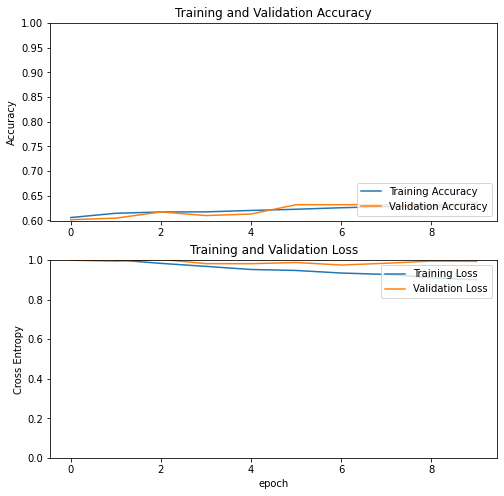

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [54]:
### Fine Tuning The model

In [55]:
base_model.trainable = True

In [56]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

In [57]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [58]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,230,277
Non-trainable params: 396,544
_________________________________________________________________


In [60]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 58


In [63]:
epochs= 20

history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=epochs, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/20
478/478 [==============================] - 920s 2s/step - loss: 0.6988 - accuracy: 0.7320 - val_loss: 1.0182 - val_accuracy: 0.6380
Epoch 2/20
478/478 [==============================] - 921s 2s/step - loss: 0.6702 - accuracy: 0.7454 - val_loss: 1.0103 - val_accuracy: 0.6222
Epoch 3/20
478/478 [==============================] - 923s 2s/step - loss: 0.6127 - accuracy: 0.7641 - val_loss: 1.0202 - val_accuracy: 0.6380
Epoch 4/20
478/478 [==============================] - 938s 2s/step - loss: 0.5510 - accuracy: 0.7974 - val_loss: 1.0489 - val_accuracy: 0.6243
Epoch 5/20
478/478 [==============================] - 1071s 2s/step - loss: 0.4849 - accuracy: 0.8238 - val_loss: 1.0892 - val_accuracy: 0.6233
Epoch 6/20
478/478 [==============================] - 1132s 2s/step - loss: 0.4266 - accuracy: 0.8543 - val_loss: 1.1155 - val_accuracy: 0.6086
Epoch 7/20
478/478 [==============================] - 1771s 4s/step - loss: 0.3776 - accuracy: 0.8738 - val_loss: 1.1855 - val_accuracy: 0.6

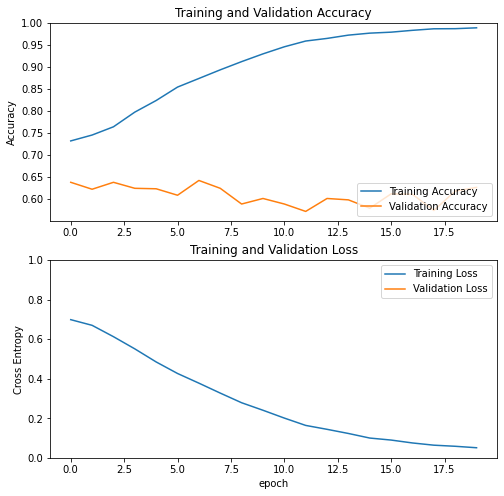

In [64]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [65]:
#optimize the model for inference
mode = "default"

if mode == 'Storage':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
  optimization = tf.lite.Optimize.DEFAULT
  
optimization

<Optimize.DEFAULT: 'DEFAULT'>

In [19]:
saved_model_dir = 'Classifier-2021/fine_tuned'
tf.keras.models.save_model(model, saved_model_dir)

2021-08-14 18:24:10.680972: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/hum/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: Classifier-2021/fine_tuned/assets


INFO:tensorflow:Assets written to: Classifier-2021/fine_tuned/assets


In [13]:
#load the saved model
model = keras.models.load_model('Classifier-2021/fine_tuned/')

In [14]:
model.save('retinopathy_model.h5')


/home/hum/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [20]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

2021-08-14 18:24:49.105190: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:345] Ignored output_format.
2021-08-14 18:24:49.105244: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:348] Ignored drop_control_dependency.
2021-08-14 18:24:49.105256: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored change_concat_input_ranges.
2021-08-14 18:24:49.240530: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: Classifier-2021/fine_tuned
2021-08-14 18:24:49.336493: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2021-08-14 18:24:49.336543: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: Classifier-2021/fine_tuned
2021-08-14 18:24:49.828805: I tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-08-14 18:24:51.346978: I tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: 

10347096

In [21]:
# Test the TFLITE model
interpretor = tf.lite.Interpreter(model_content=tflite_model)
interpretor.allocate_tensors()

#details
input_index = interpretor.get_input_details()[0]["index"]
output_index = interpretor.get_output_details()[0]["index"]

In [22]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
#preds = model.predict(image)


In [23]:
test_batches = tf.data.Dataset.list_files(str(data_dir/'train/*/*'))

test_batches = test_bfrom keras.applications.resnet50 import decode_predictions
atches.map(process_path).batch(1).prefetch(1)